<img src="https://scientists4future-dortmund.de/assets/img/banner_web.svg" width="100%" alt="banner">


# Analyse öffentlicher Daten zur Meereisbedeckung an den Polen


Die Daten stammen aus dieser Veröffentlichung 

> Fetterer, F., K. Knowles, W. N. Meier, M. Savoie, and A. K. Windnagel. 2017, updated daily. Sea Ice Index, Version 3. northern and southern hemisphere csv data. Boulder, Colorado USA. NSIDC: National Snow and Ice Data Center. doi: https://doi.org/10.7265/N5K072F8. as of 2019-06-26T16:27:00.

Download Links:
* ftp://sidads.colorado.edu/DATASETS/NOAA/G02135/south/daily/data/S_seaice_extent_daily_v3.0.csv
* ftp://sidads.colorado.edu/DATASETS/NOAA/G02135/north/daily/data/N_seaice_extent_daily_v3.0.csv


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import sem

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

%matplotlib inline

In [2]:
def read_icedata(path):
    # skip column containing units
    df = pd.read_csv(path, skiprows=[1])
    
    # remove whitespace from column names, make lowercase
    df.columns = [c.strip().lower() for c in df.columns]
    
    # convert Year/Month/Date columns into a timestamp
    df['date'] = pd.to_datetime(df[['year', 'month', 'day']])
    
    # Use date as Index
    df.set_index('date', inplace=True)
    
    # remove unuseful columns
    df.drop(['source data', 'year', 'month', 'day'], axis=1, inplace=True)
    
    
    # only values every two days before 1990, resample and interpolate to have values for every day
    df = df.resample('1d').interpolate('linear', limit=1)
    return df

dfs = read_icedata('data/2019-06-26/S_seaice_extent_daily_v3.0.csv')
dfn = read_icedata('data/2019-06-26/N_seaice_extent_daily_v3.0.csv')

df = dfs.join(dfn, lsuffix='_antarctic', rsuffix='_arctic', how='outer')

In [3]:
df.describe()

,extent_antarctic,missing_antarctic,extent_arctic,missing_arctic
count,14812.000000,14812.000000,14812.000000,14812.0
mean,11.593403,0.000006,11.464981,0.0
std,5.637242,0.000303,3.240731,0.0
min,2.080000,0.000000,3.340000,0.0
25%,5.982000,0.000000,8.795750,0.0
50%,12.468500,0.000000,12.163000,0.0
75%,17.159500,0.000000,14.286000,0.0
max,20.201000,0.024000,16.635000,0.0


In [4]:
df.index.min(), df.index.max()

(Timestamp('1978-10-26 00:00:00'), Timestamp('2019-06-24 00:00:00'))

In [5]:
df.dropna().index.to_series().diff().value_counts()

1 days     14810
41 days        1
Name: date, dtype: int64

In [6]:
df.head()

,extent_antarctic,missing_antarctic,extent_arctic,missing_arctic
date,,,,
1978-10-26,17.6240,0.0,10.2310,0.0
1978-10-27,17.7135,0.0,10.3255,0.0
1978-10-28,17.8030,0.0,10.4200,0.0
1978-10-29,17.7365,0.0,10.4885,0.0
1978-10-30,17.6700,0.0,10.5570,0.0


In [7]:
df.corr()

,extent_antarctic,missing_antarctic,extent_arctic,missing_arctic
extent_antarctic,1.000000,-0.005518,-0.921937,NaN
missing_antarctic,-0.005518,1.000000,-0.004249,NaN
extent_arctic,-0.921937,-0.004249,1.000000,NaN
missing_arctic,NaN,NaN,NaN,NaN


## Daten visualisieren

Wir plotten einfach erstmal die Menge Eis gegen das Datum

Text(0, 0.5, 'sea ice coverage / $10^6$ km$^2$')

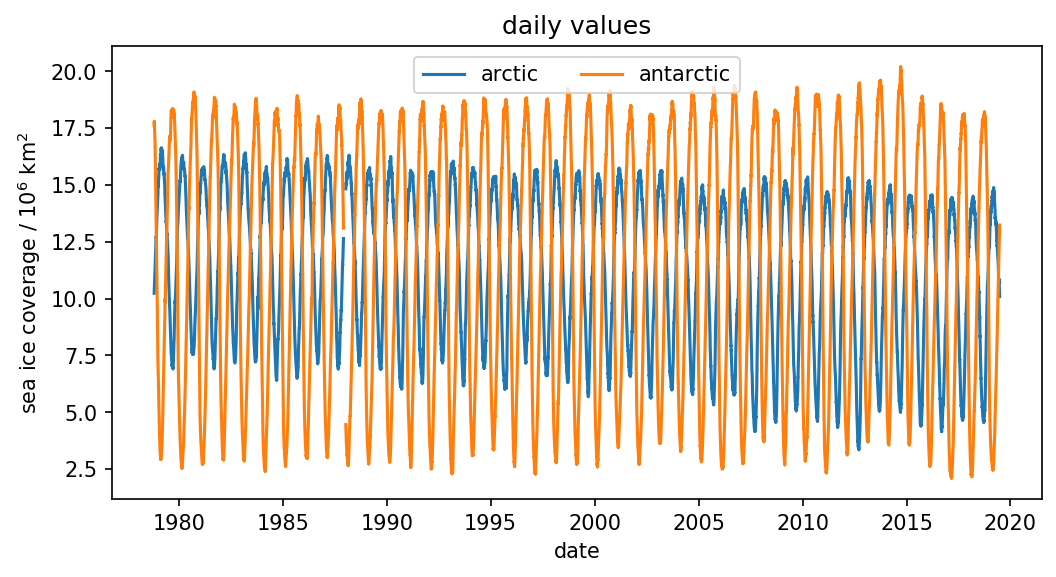

In [8]:
plt.figure(figsize=(8,4), dpi=150)


for label in ('arctic', 'antarctic'):
    
    plt.plot(df.index, df['extent_' + label], label=label)

plt.legend(ncol=2, loc='upper center')
plt.title('daily values')
plt.xlabel('date')
plt.ylabel('sea ice coverage / $10^6$ km$^2$')

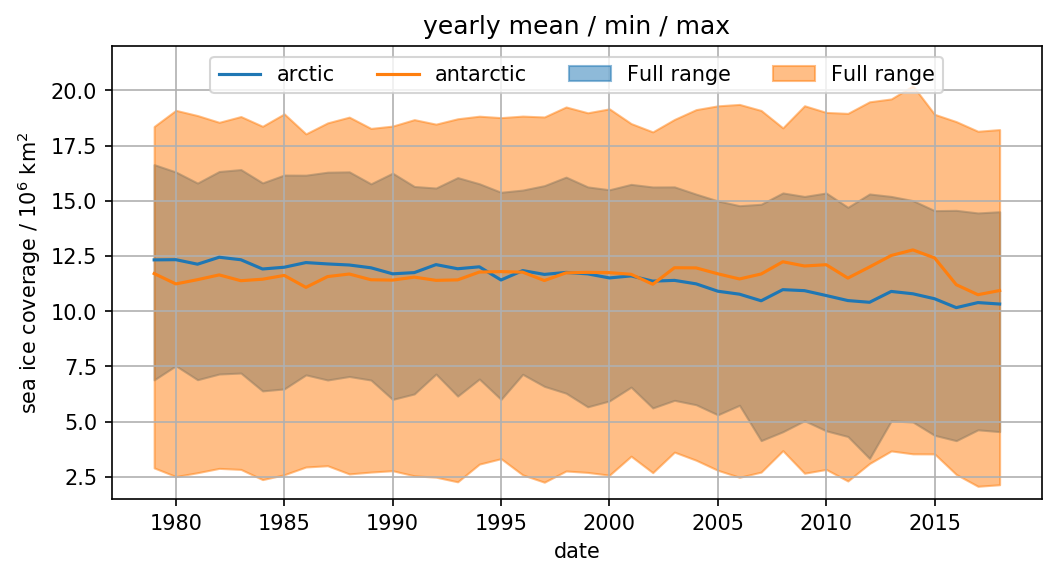

In [9]:
plt.figure(figsize=(8,4), dpi=150)


for label in ['arctic', 'antarctic']:
    
    # let's take only full years
    full_years = df.loc['1979-01-01':'2018-12-31']
    
    # aggregate data of each year, using mean, min, max
    by_year = full_years.groupby(full_years.index.year)['extent_' + label].agg(['mean', 'min', 'max'])
    
    l, = plt.plot(by_year.index, by_year['mean'], label=label)

    plt.fill_between(
        by_year.index,
        by_year['min'],
        by_year['max'],
        alpha=0.5,
        color=l.get_color(),
        label="Full range"
    )

plt.legend(ncol=4,loc='upper center')
plt.title('yearly mean / min / max')
plt.xlabel('date')
plt.ylim(1.5, 22)
plt.ylabel('sea ice coverage / $10^6$ km$^2$')
plt.grid()

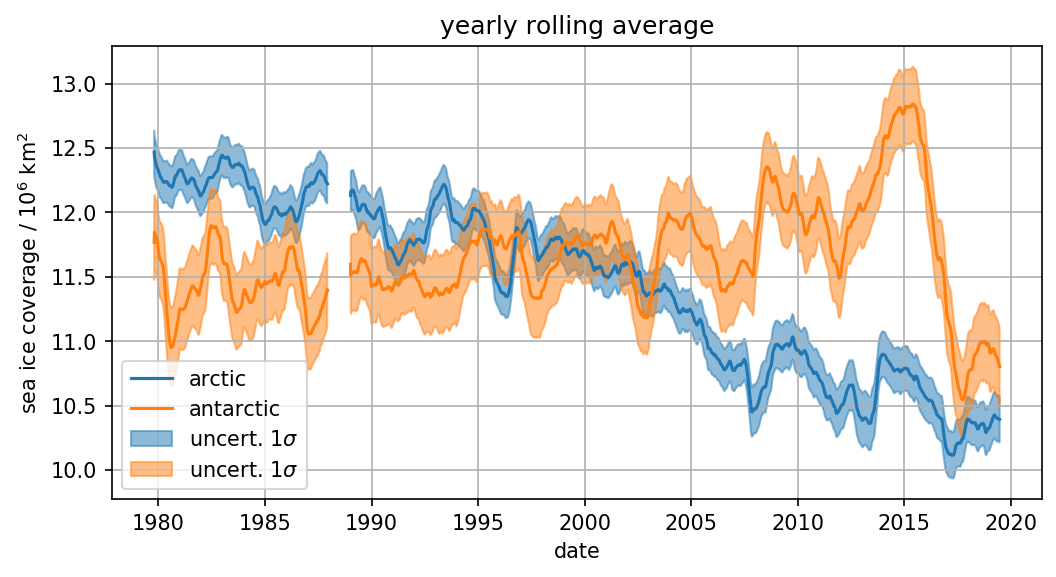

In [10]:
plt.figure(figsize=(8,4), dpi=150)


for label in ['arctic', 'antarctic']:
    
    # do not show data where less than 300 points were averaged
    rolled = df['extent_' + label].rolling('365d', min_periods=360)
    
    ice_mean = rolled.mean()
    # std error of the mean
    ice_mean_err = rolled.agg(sem)
    
    l, = plt.plot(ice_mean.index, ice_mean, label=label)

    plt.fill_between(
        ice_mean.index,
        ice_mean - ice_mean_err,
        ice_mean + ice_mean_err,
        alpha=0.5,
        color=l.get_color(),
        label="uncert. 1$\sigma$"
    )

plt.legend()
plt.title('yearly rolling average')
plt.xlabel('date')
plt.ylabel('sea ice coverage / $10^6$ km$^2$')
plt.grid()

Text(0, 0.5, 'sea ice coverage / $10^6$ km$^2$')

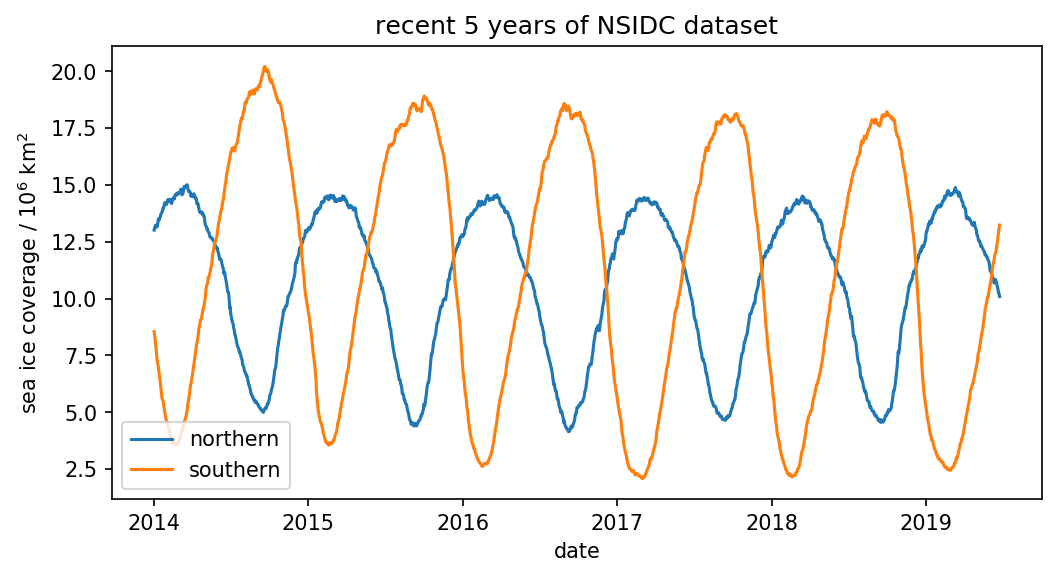

In [11]:
plt.figure(figsize=(8,4), dpi=150)

last_5 = df.loc['2014-01-01':]

plt.plot(last_5.index, last_5['extent_arctic'], label='northern')
plt.plot(last_5.index, last_5['extent_antarctic'], label='southern')

plt.legend()
plt.title('recent 5 years of NSIDC dataset')
plt.xlabel('date')
plt.ylabel('sea ice coverage / $10^6$ km$^2$')

Text(0, 0.5, 'sea ice coverage / $10^6$ km$^2$')

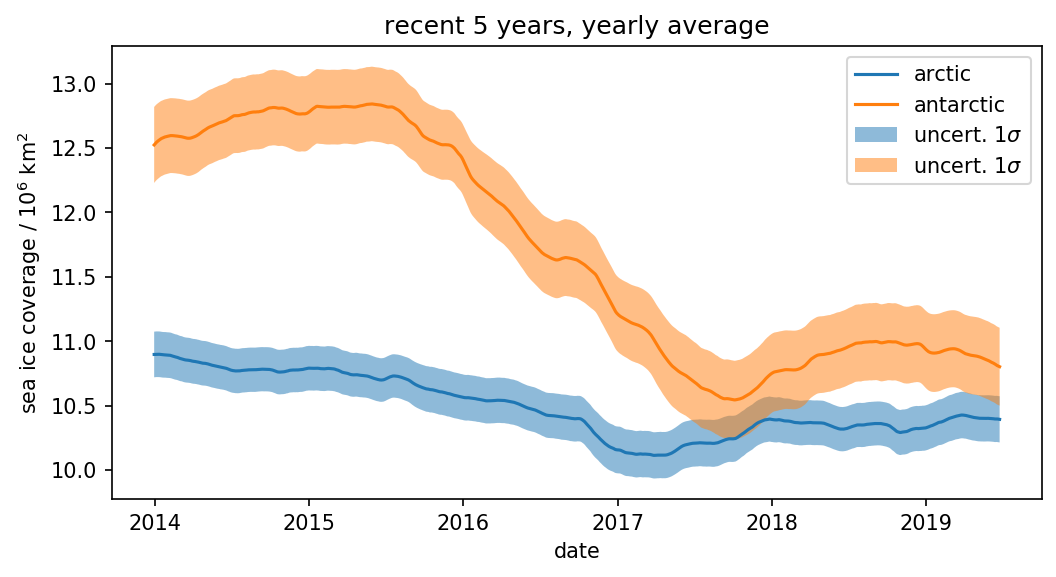

In [20]:
plt.figure(figsize=(8,4), dpi=150)


last_5_r = df['2013-01-01':].rolling('365d', min_periods=365).agg(['mean', 'count', 'std', sem])


for label in ['arctic', 'antarctic']:
    k = 'extent_' + label
    plt.plot(last_5_r.index, last_5_r[k, 'mean'], label=label)

    plt.fill_between(
        last_5_r.index,
        last_5_r[k, 'mean'] - last_5_r[k, 'sem'] ,
        last_5_r[k, 'mean'] + last_5_r[k, 'sem'] ,
        alpha=0.5,
        label="uncert. 1$\sigma$"
    )

plt.legend()
plt.title('recent 5 years, yearly average')
plt.xlabel('date')
plt.ylabel('sea ice coverage / $10^6$ km$^2$')

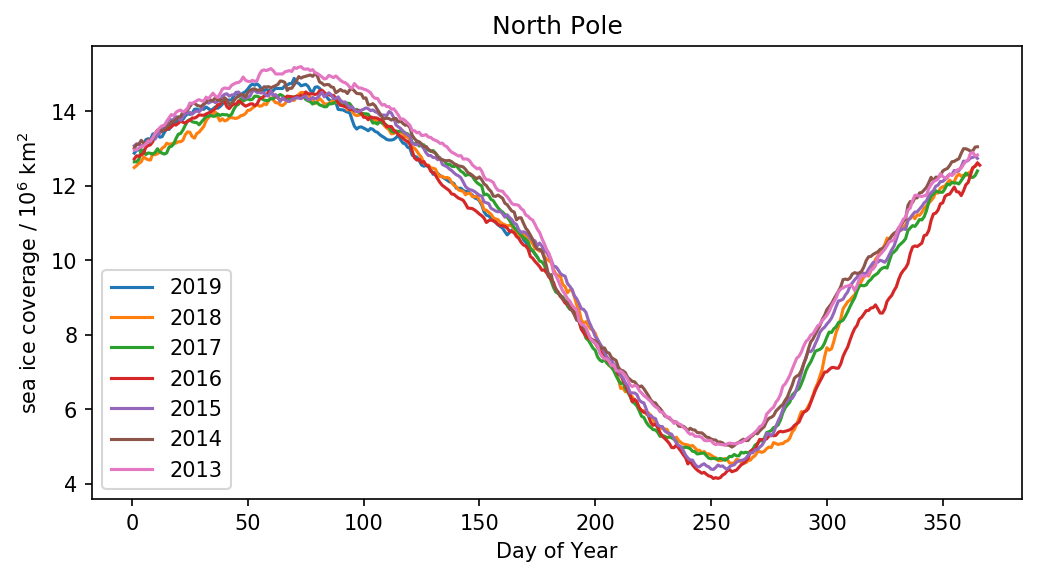

In [13]:
plt.figure(figsize=(8,4), dpi=150)
plt.title('North Pole')

for y in range(2019, 2012, -1):
    sl = slice(f'{y}-01-01', f'{y}-12-31')
    
    plt.plot(
        df[sl].index.dayofyear,
        df[sl]['extent_arctic'],
        label=y,
    )
    
plt.ylabel('sea ice coverage / $10^6$ km$^2$')
plt.xlabel('Day of Year')
plt.legend()

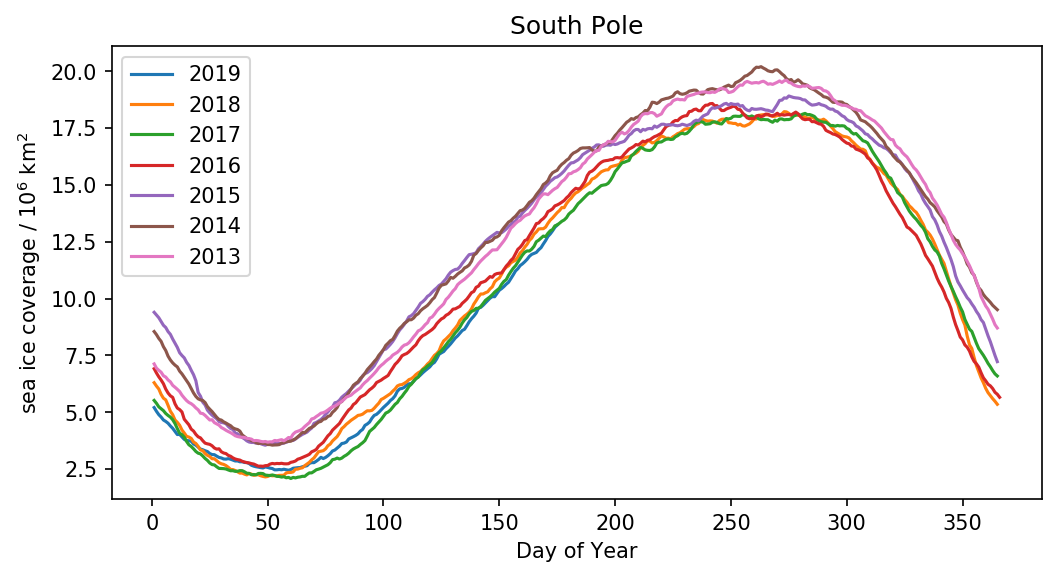

In [14]:
plt.figure(figsize=(8,4), dpi=150)
plt.title('South Pole')

for y in range(2019, 2012, -1):
    sl = slice(f'{y}-01-01', f'{y}-12-31')
    
    plt.plot(
        df[sl].index.dayofyear,
        df[sl]['extent_antarctic'],
        label=y,
    )
    
plt.ylabel('sea ice coverage / $10^6$ km$^2$')
plt.xlabel('Day of Year')
plt.legend()

In [15]:
np.arange(2020,2009)

array([], dtype=int64)

In [16]:
def plot_critical_years(df, start, end, area='arctic'):
    plt.figure(figsize=(8,4), dpi=150)
    
    def percentile(p):
        def calc_perc(s):
            return np.nanpercentile(s, p)
        
        calc_perc.__name__ = f'{p}%'
        return calc_perc

    before = df[:f'{start - 1}-12-31']
    before = before.groupby(before.index.dayofyear)
    before = before['extent_' + area].agg(['mean', 'std', percentile(14), percentile(86)])

    plt.plot(
        before.index,
        before['mean'],
        label=f'daily avg until {start}'
    )

    plt.fill_between(
        before.index,
        before['14%'],
        before['86%'],
        alpha=0.5,
        label='1-σ quantiles'
    )

    for y in range(start, end):
        sl = slice(f'{y}-01-01', f'{y}-12-31') 
        plt.plot(
            df[sl].index.dayofyear,
            df[sl]['extent_' + area],
            label=y,
        )

    plt.legend()
    plt.xlabel('days of year')
    plt.ylabel('sea ice coverage / $10^6$ km$^2$')

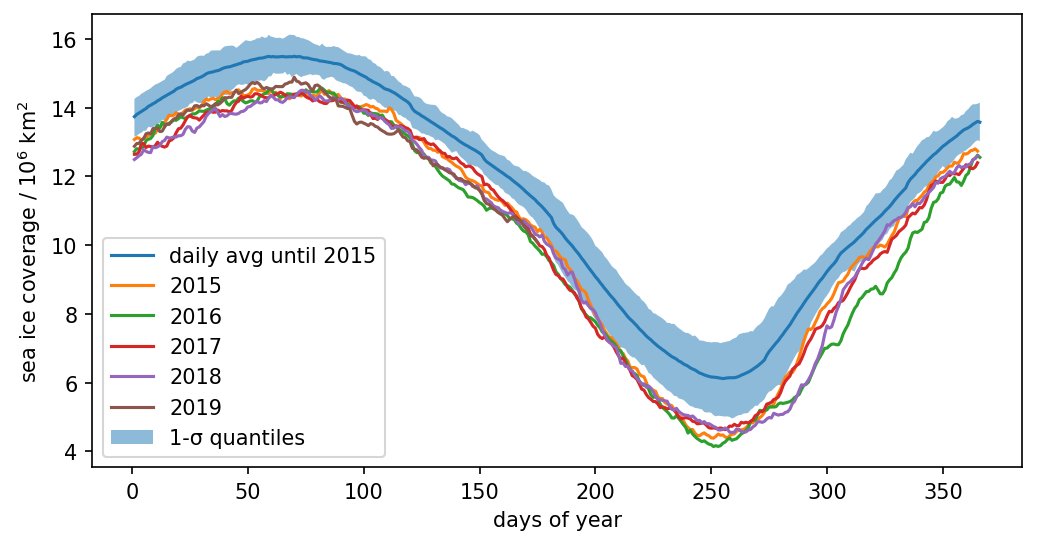

In [17]:
plot_critical_years(df, 2015, 2020)

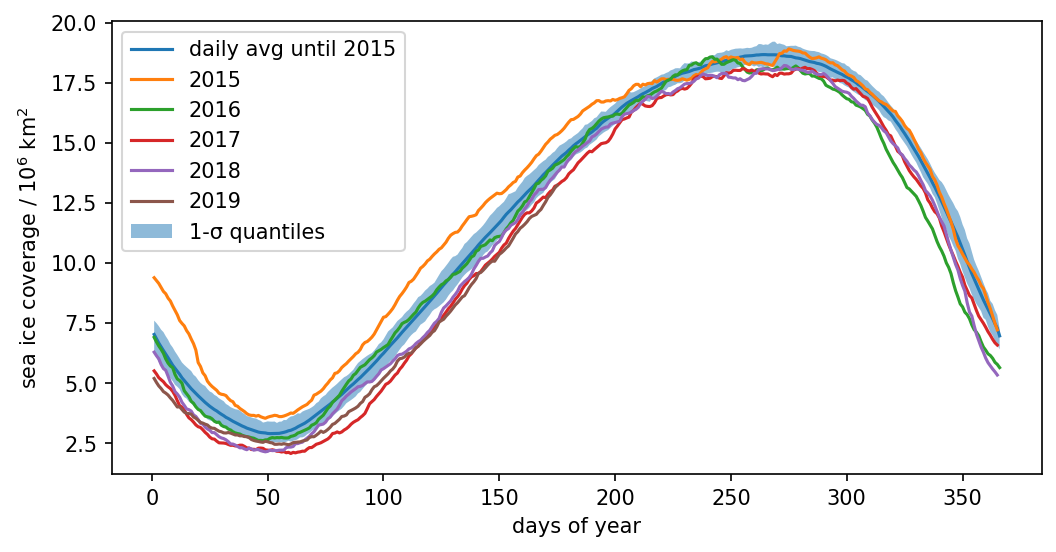

In [18]:
plot_critical_years(df, 2015, 2020, area='antarctic')